In [1]:
# Import needed libraries

import findspark
findspark.init('/usr/hdp/2.6.5.0-292/spark2')

# Create a Spark Context which will be used for distributed data processing

import pyspark
sc = pyspark.SparkContext(appName="Twitter Topic Sentiment")

import string

import re as re

import nltk

import time

from pyspark.sql import SQLContext

from pyspark.sql.types import *

from pyspark.sql.functions import monotonically_increasing_id

from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import RegexTokenizer, Tokenizer, StopWordsRemover, CountVectorizer, CountVectorizerModel, StopWordsRemover

from pyspark.mllib.clustering import LDA, LDAModel

nltk.download('stopwords')

from nltk.corpus import stopwords

from pyspark.mllib.linalg import Vector as oldVector, Vectors as oldVectors

from pyspark.ml.linalg import Vector as newVector, Vectors as newVectors

from pyspark.ml.feature import IDF

import numpy as np

import matplotlib.pyplot as plt

import pyspark.sql.functions as func

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vagrant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Create an SQL Context which will be used for sql like distriburted data processing

# As I get more familiar with what technology to use where I will be switching between using pyspard RDDs,

# pyspark dataframes, and pandas dataframes

sqlContext = SQLContext(sc)

In [3]:
# Hadoop is the filesystem being used. This is a three node virtual cluster

# Read in data from Hadoop

ITData = sc.textFile("hdfs:////user/vagrant/practicum/input")

In [4]:
# Output sample of data

ITData.take(5)

[u'timetext,tweetid,tweetsource,tweettruncated,tweettext,tweetuserscreenname,tweetuserid,tweetuserlocation,tweetuserdescription,tweetuserfollowerscount,tweetuserstatusescount,tweetusertimezone,tweetusergioenabled,tweetuserlang,tweetcoordinatescoordinates,tweetplacecountry,tweetplacecountrycode,tweetplacefullname,tweetplacename,tweetplacetype',
 u'20180606021849,1004185815147163648,a hrefhttptwittercomdownloadandroid relnofollowTwitter for Androida,False,AgeroNews data science teams presentation at SparkAISummit today httpstco7F2IAUvN4o,chyuck,139348324,Stoneham  MA,Software Engineer Manchester United FC and FC Lokomotiv Moscow fan Interests soccer  programming  foosball  cross country running  chess  melodic death metal,57,1413,,True,en,,,,,,',
 u'20180606021850,1004185819119259648,a hrefhttptwittercomdownloadiphone relnofollowTwitter for iPhonea,False,RT IAFsite When one door closes  another opens  The IAF is planning to improve its equipment  replacing old aircraft and systems  while

In [5]:
# Count number of records loaded to pyspark RDD

ITData.count()

104783

In [6]:
# By default, data is partitioned based on the data size

# Check the number of partitions created

ITData.getNumPartitions()

6

In [7]:
# Twitter data was collected and batched in files with each file having a file header

# Extract the first file header from the dataset and display

# This will be used later to remove all headers from the dataset

header = ITData.first()
header

u'timetext,tweetid,tweetsource,tweettruncated,tweettext,tweetuserscreenname,tweetuserid,tweetuserlocation,tweetuserdescription,tweetuserfollowerscount,tweetuserstatusescount,tweetusertimezone,tweetusergioenabled,tweetuserlang,tweetcoordinatescoordinates,tweetplacecountry,tweetplacecountrycode,tweetplacefullname,tweetplacename,tweetplacetype'

In [8]:
# Filter all of the headers from the data set

# Count the number of records remaining in the data set

# If 10 files were read from Hadoop, this count should be 10 less

ITData_NoHeader = ITData.filter(lambda row : row != header)
ITData_NoHeader.count()

104777

In [9]:
# We now have an RDD with not header information

# In preparation for creating a dataframe from the RDD, create a schema based on the original header

schema = StructType([
    StructField('timetext', StringType(), nullable=True),
    StructField('tweet_id', StringType(), nullable=True),
    StructField('tweet_source', StringType(), nullable=True),
    StructField('tweet_truncated', StringType(), nullable=True),
    StructField('tweet_text', StringType(), nullable=True),
    StructField('tweet_user_screen_name', StringType(), nullable=True),
    StructField('tweet_user_id', StringType(), nullable=True),
    StructField('tweet_user_location', StringType(), nullable=True),
    StructField('tweet_user_description', StringType(), nullable=True),
    StructField('tweet_user_followers_count', StringType(), nullable=True),
    StructField('tweet_user_statuses_count', StringType(), nullable=True),
    StructField('tweet_user_time_zone', StringType(), nullable=True),
    StructField('tweet_user_geo_enabled', StringType(), nullable=True),
    StructField('tweet_user_lang', StringType(), nullable=True),
    StructField('tweet_coordinates_coordinates', StringType(), nullable=True),
    StructField('tweet_place_country', StringType(), nullable=True),
    StructField('tweet_place_country_code', StringType(), nullable=True),
    StructField('tweet_place_full_name', StringType(), nullable=True),
    StructField('tweet_place_name', StringType(), nullable=True),
    StructField('tweet_place_type', StringType(), nullable=True)
])

# Create a dataframe from the RDD with schema

ITData_df = sqlContext.createDataFrame(ITData_NoHeader.map(lambda s: s.split(",")), schema)

ITData_df.printSchema()

root
 |-- timetext: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet_source: string (nullable = true)
 |-- tweet_truncated: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- tweet_user_screen_name: string (nullable = true)
 |-- tweet_user_id: string (nullable = true)
 |-- tweet_user_location: string (nullable = true)
 |-- tweet_user_description: string (nullable = true)
 |-- tweet_user_followers_count: string (nullable = true)
 |-- tweet_user_statuses_count: string (nullable = true)
 |-- tweet_user_time_zone: string (nullable = true)
 |-- tweet_user_geo_enabled: string (nullable = true)
 |-- tweet_user_lang: string (nullable = true)
 |-- tweet_coordinates_coordinates: string (nullable = true)
 |-- tweet_place_country: string (nullable = true)
 |-- tweet_place_country_code: string (nullable = true)
 |-- tweet_place_full_name: string (nullable = true)
 |-- tweet_place_name: string (nullable = true)
 |-- tweet_place_type: string (nullable =

In [10]:
# First convert dataframe to rdd

# Use map lambda to select the tweet_text column and filter out all empty records

tweet = ITData_df.rdd.map(lambda x: x['tweet_text']).filter(lambda x: x is not None)

In [11]:
# Retrieve stop words. Note we may need to add to the stop words list based on topic model results

StopWords = stopwords.words("english")

In [12]:
# Further clean tweets, split them out into individual words, and number them by adding an index

tokens = tweet.map(lambda document: document.strip().lower()) \
              .map(lambda document: re.split(" ", document)) \
              .map(lambda word: [x for x in word if x.isalpha()]) \
              .map(lambda word: [x for x in word if len(x) > 3]) \
              .map(lambda word: [x for x in word if x not in StopWords]) \
              .zipWithIndex()

In [13]:
# tokens is an RDD, display the first 5 records

tokens.take(5)

[([u'ageronews',
   u'data',
   u'science',
   u'teams',
   u'presentation',
   u'sparkaisummit',
   u'today'],
  0),
 ([u'iafsite',
   u'door',
   u'closes',
   u'another',
   u'opens',
   u'planning',
   u'improve',
   u'equipment',
   u'replacing',
   u'aircraft',
   u'systems'],
  1),
 ([u'kremlintrolls',
   u'breaking',
   u'facebook',
   u'given',
   u'least',
   u'four',
   u'chinese',
   u'companies',
   u'access',
   u'user',
   u'data',
   u'flagged',
   u'intellige'],
  2),
 ([u'already',
   u'didnt',
   u'graduate',
   u'honors',
   u'didnt',
   u'name',
   u'graduation',
   u'dinner',
   u'dinner',
   u'whose',
   u'name',
   u'didnt',
   u'read',
   u'java',
   u'professor',
   u'gave',
   u'lecture',
   u'grades',
   u'dont',
   u'matter',
   u'super',
   u'dont',
   u'care',
   u'errors'],
  3),
 ([u'breaking',
   u'facebook',
   u'given',
   u'least',
   u'chinese',
   u'companies',
   u'access',
   u'user',
   u'data',
   u'flagged',
   u'intelligence'],
  4)]

In [14]:
# Create a new dataframe from the above RDD, adding column names

tweet_df = sqlContext.createDataFrame(tokens, ["tweet_words", 'index'])

In [15]:
# Display the first 5 records of the dataframe

tweet_df.show(5)

+--------------------+-----+
|         tweet_words|index|
+--------------------+-----+
|[ageronews, data,...|    0|
|[iafsite, door, c...|    1|
|[kremlintrolls, b...|    2|
|[already, didnt, ...|    3|
|[breaking, facebo...|    4|
+--------------------+-----+
only showing top 5 rows



In [16]:
# Prepare for Topic Modeling

print(time.strftime('%m%d%Y %H:%M:%S'))
cv = CountVectorizer(inputCol="tweet_words", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(tweet_df)
print(time.strftime('%m%d%Y %H:%M:%S'))

06272018 14:44:31
06272018 14:44:58


In [17]:
print(time.strftime('%m%d%Y %H:%M:%S'))
result_cv = cvmodel.transform(tweet_df)
print(time.strftime('%m%d%Y %H:%M:%S'))

06272018 14:45:05
06272018 14:45:06


In [18]:
result_cv.show(1)

+--------------------+-----+--------------------+
|         tweet_words|index|        raw_features|
+--------------------+-----+--------------------+
|[ageronews, data,...|    0|(5000,[0,19,44,99...|
+--------------------+-----+--------------------+
only showing top 1 row



In [19]:
rs = result_cv.rdd.map(lambda (x, y, z): (x, y, oldVectors.fromML(z)))

In [20]:
rs_df = rs.toDF(['tweet_words', 'index', 'raw_features'])

In [21]:
rs.take(1)

[([u'ageronews',
   u'data',
   u'science',
   u'teams',
   u'presentation',
   u'sparkaisummit',
   u'today'],
  0,
  SparseVector(5000, {0: 1.0, 19: 1.0, 44: 1.0, 993: 1.0, 2006: 1.0, 4829: 1.0}))]

In [22]:
rs_df.show(1)

+--------------------+-----+--------------------+
|         tweet_words|index|        raw_features|
+--------------------+-----+--------------------+
|[ageronews, data,...|    0|(5000,[0,19,44,99...|
+--------------------+-----+--------------------+
only showing top 1 row



In [23]:
print(time.strftime('%m%d%Y %H:%M:%S'))
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)
print(time.strftime('%m%d%Y %H:%M:%S'))

06272018 14:45:42
06272018 14:46:03


In [24]:
# Run the LDA Topic Modeler

# Note the time before and after is printed in order to find out how much time it takes to process x number of records

print(time.strftime('%m%d%Y %H:%M:%S'))
num_topics = 10
max_iterations = 20
lda_model = LDA.train(rs_df['index', 'raw_features'].rdd.map(list), k=num_topics, maxIterations=max_iterations)
print(time.strftime('%m%d%Y %H:%M:%S'))

06272018 14:46:26
06272018 14:50:35


In [25]:
vocabArray = cvmodel.vocabulary

In [26]:
# Set the top number of topics to write to spark

wordNumbers = 20
topicIndices = sc.parallelize(lda_model.describeTopics(maxTermsPerTopic = wordNumbers))

In [27]:
def topic_render(topic):
    terms = topic[0]
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result

In [28]:
print(time.strftime('%m%d%Y %H:%M:%S'))
topics_final = topicIndices.map(lambda topic:
                               topic_render(topic)).collect()
print(time.strftime('%m%d%Y %H:%M:%S'))

06272018 14:57:18
06272018 14:57:18


In [29]:
# Display topics

for topic in range(len(topics_final)):
    print("Topic" + str(topic) + ":")
    for term in topics_final[topic]:
        print(term)
    print('\n')

Topic0:
data
technology
facebook
sure
computer
chinese
saved
erased
manage
ithegiovanni
cloud
robotics
access
systems
developer
blockchain
hybrid
companies
user
flagged


Topic1:
data
technology
facebook
computer
sure
manage
saved
ithegiovanni
erased
cloud
chinese
robotics
systems
access
developer
blockchain
hybrid
companies
intelligence
internet


Topic2:
data
technology
facebook
computer
sure
cloud
manage
saved
ithegiovanni
erased
chinese
robotics
systems
access
blockchain
developer
companies
user
like
science


Topic3:
data
technology
facebook
sure
manage
saved
ithegiovanni
erased
computer
chinese
cloud
robotics
systems
access
developer
blockchain
companies
user
science
hybrid


Topic4:
data
technology
facebook
computer
sure
cloud
chinese
manage
saved
erased
ithegiovanni
robotics
access
developer
systems
blockchain
companies
hybrid
intelligence
user


Topic5:
data
technology
facebook
computer
sure
manage
saved
ithegiovanni
cloud
erased
chinese
robotics
access
developer
systems
block

In [30]:
# The above above relates topics to the terms I searched in Twitter

# For sentiment analysis, I would like to rate the actual search terms.

# For this I will build a python array with those search terms

search_terms = ["machine_learning", "computer_programmer", "database_engineer", "network_engineer", \
                "data_scientist", "systems_engineer", "data_analyst", "data_architect", "etl_architect", \
                "web_programmer", "automation_engineer", "data_processing", "application_engineer", \
                "software_engineer", "software_developer", "information_architect", "security_analyst", \
                "business_intelligence", "enterprise_architect", "solution_architect", "data_warehouse", \
                "information_technology", "data", "java", "iot", "computer", "systems", "technology", \
                "etl", "devops", "cloud", "developer", "programmer", "ai"]

search_terms

['machine_learning',
 'computer_programmer',
 'database_engineer',
 'network_engineer',
 'data_scientist',
 'systems_engineer',
 'data_analyst',
 'data_architect',
 'etl_architect',
 'web_programmer',
 'automation_engineer',
 'data_processing',
 'application_engineer',
 'software_engineer',
 'software_developer',
 'information_architect',
 'security_analyst',
 'business_intelligence',
 'enterprise_architect',
 'solution_architect',
 'data_warehouse',
 'information_technology',
 'data',
 'java',
 'iot',
 'computer',
 'systems',
 'technology',
 'etl',
 'devops',
 'cloud',
 'developer',
 'programmer',
 'ai']

In [31]:
# Python function to search for topics within a tweet

# Function will return the topic and the related tweet or NA is no topic found and the related tweet

def SearchTopics(topics, tweet_text):
    for term in topics:
        result = tweet_text.find(term)
        if result > -1:
            return term, tweet_text
    return 'NA', tweet_text

In [32]:
# While removing stopwords helps obtain valid topics it will not help with sentiment analysis

# With topics in hand, topics_final, we will use tweets where stop words have not been removed

tweet.take(5)

[u'AgeroNews data science teams presentation at SparkAISummit today httpstco7F2IAUvN4o',
 u'RT IAFsite When one door closes  another opens  The IAF is planning to improve its equipment  replacing old aircraft and systems  while',
 u'RT KremlinTrolls BREAKING Facebook has given at least four Chinese companies access to user data One has been flagged by US intellige',
 u'So I already didnt graduate with honors they didnt say my name at the graduation dinner  I was one of VERY FEW at the dinner whose name didnt get read so after my Java professor gave us a lecture about how grades dont matter I SUPER dont care about errors in the HW',
 u'RT Breaking911 BREAKING Facebook has given at least 4 Chinese companies access to user data One has been flagged by US intelligence a']

In [33]:
# Search each tweet for topics returning only tweets that match

# SearchTopics will return both the topic and the related tweet

# Sentiment will be done on these tweets

topic_tweet = tweet.map(lambda x: SearchTopics(search_terms, x)).filter(lambda x: x[0] != 'NA')

In [34]:
# Display 5 topic tweet combinations

topic_tweet.take(10)

[('data',
  u'AgeroNews data science teams presentation at SparkAISummit today httpstco7F2IAUvN4o'),
 ('systems',
  u'RT IAFsite When one door closes  another opens  The IAF is planning to improve its equipment  replacing old aircraft and systems  while'),
 ('data',
  u'RT KremlinTrolls BREAKING Facebook has given at least four Chinese companies access to user data One has been flagged by US intellige'),
 ('data',
  u'RT Breaking911 BREAKING Facebook has given at least 4 Chinese companies access to user data One has been flagged by US intelligence a'),
 ('data',
  u'RT KremlinTrolls BREAKING Facebook has given at least four Chinese companies access to user data One has been flagged by US intellige'),
 ('data',
  u'RT PoliticalShort Facebook confirmed that 4 Chinese device makers were among those that had broad access to customer data under a program'),
 ('iot',
  u'bruabreus thehorrorpics youlovemypugs pussyriotx AI QUE HORROR KKKKKKKKKKKKKKK'),
 ('data',
  u'RT Reuters Facebook confir

In [35]:
# Setup sentiment analysis

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

/home/vagrant/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vagrant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [36]:
# Python function to print the sentiment scores

# This function will have topic and related tweet as in put

# This function will perform sentiment analysis and output topic, tweet, and sentiment

# Also note this function will only return the compound portion of the sentiment

# Revert sigpipe to default behavior

def print_sentiment_scores(topic, sentence):
    snt = SentimentIntensityAnalyzer().polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
    print(str(snt))
    return(topic, sentence, str(snt.get('compound')))

In [37]:
# Retrieve sentiment for each topic, tweet

topic_tweet_sentiment = topic_tweet.map(lambda x: print_sentiment_scores(x[0], x[1]))

In [38]:
# Display sentiment

topic_tweet_sentiment.take(10)

[('data',
  u'AgeroNews data science teams presentation at SparkAISummit today httpstco7F2IAUvN4o',
  '0.0'),
 ('systems',
  u'RT IAFsite When one door closes  another opens  The IAF is planning to improve its equipment  replacing old aircraft and systems  while',
  '0.4404'),
 ('data',
  u'RT KremlinTrolls BREAKING Facebook has given at least four Chinese companies access to user data One has been flagged by US intellige',
  '0.0'),
 ('data',
  u'RT Breaking911 BREAKING Facebook has given at least 4 Chinese companies access to user data One has been flagged by US intelligence a',
  '0.4767'),
 ('data',
  u'RT KremlinTrolls BREAKING Facebook has given at least four Chinese companies access to user data One has been flagged by US intellige',
  '0.0'),
 ('data',
  u'RT PoliticalShort Facebook confirmed that 4 Chinese device makers were among those that had broad access to customer data under a program',
  '0.0'),
 ('iot',
  u'bruabreus thehorrorpics youlovemypugs pussyriotx AI QUE HORROR

In [39]:
# Assign the topic and sentiment only

topic_tweet_sentiment_pair = topic_tweet_sentiment.map(lambda x: (x[0], x[2]))

In [40]:
# Display topic, sentiment combination

topic_tweet_sentiment_pair.take(10)

[('data', '0.0'),
 ('systems', '0.4404'),
 ('data', '0.0'),
 ('data', '0.4767'),
 ('data', '0.0'),
 ('data', '0.0'),
 ('iot', '-0.6633'),
 ('data', '0.4215'),
 ('systems', '-0.7178'),
 ('iot', '-0.3744')]

In [41]:
# Convert to dataframe naming columns

topic_tweet_sentiment_pair_df = topic_tweet_sentiment_pair.toDF(['topic', 'sentiment'])

In [42]:
# Display dataframe

topic_tweet_sentiment_pair_df.show(5)

+-------+---------+
|  topic|sentiment|
+-------+---------+
|   data|      0.0|
|systems|   0.4404|
|   data|      0.0|
|   data|   0.4767|
|   data|      0.0|
+-------+---------+
only showing top 5 rows



In [43]:
# Count sentiment records

topic_tweet_sentiment_pair_df.count()

61624

In [44]:
# Create panda dataframe based on topic, sentiment dataframe

# This dataframe will enable us to plot highs, lows, and means

pdf1 = topic_tweet_sentiment_pair_df.toPandas()

In [45]:
# Check new dataframe types

pdf1.dtypes

topic        object
sentiment    object
dtype: object

In [46]:
# Sentiment is currently of type object, needs to be float

# Convert sentiment datatype to float

pdf1['sentiment'] = pdf1.sentiment.astype(float)

# Check datatypes

pdf1.dtypes

# list new panda dataframe

pdf1

,topic,sentiment
0,data,0.0000
1,systems,0.4404
2,data,0.0000
3,data,0.4767
4,data,0.0000
5,data,0.0000
6,iot,-0.6633
7,data,0.4215
8,systems,-0.7178
9,iot,-0.3744


In [47]:
# Describe data

pdf1.describe()

,sentiment
count,61624.000000
mean,0.158525
std,0.385764
min,-0.983200
25%,0.000000
50%,0.000000
75%,0.476700
max,0.983000


In [71]:
topic_groups = pdf1.groupby('topic')
topic_groups.size()

topic
ai                        17865
automation_engineer           2
business_intelligence         9
cloud                      3049
computer                   4384
computer_programmer          10
data                      24880
data_analyst                 26
data_architect                1
data_processing              12
data_scientist               48
data_warehouse                9
developer                  1569
devops                      123
etl                          50
information_architect         1
information_technology       23
iot                         486
java                        360
machine_learning            499
network_engineer              4
programmer                  152
security_analyst              3
software_developer           26
software_engineer            53
solution_architect            1
systems                    2427
systems_engineer              6
technology                 5546
dtype: int64

In [81]:
sentiment_terms1 = ['ai', 'data', 'tecnology', 'cloud']

In [82]:
pdf2 = pdf1[pdf1.topic.isin(sentiment_terms1)]
pdf2

,topic,sentiment
0,data,0.0000
2,data,0.0000
3,data,0.4767
4,data,0.0000
5,data,0.0000
7,data,0.4215
10,ai,0.0000
11,ai,0.0000
13,ai,0.0000
14,ai,-0.5267


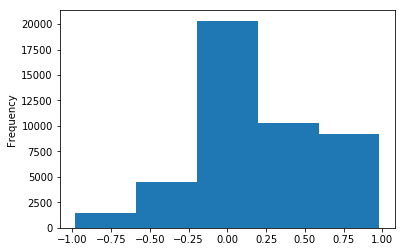

In [86]:
# Histograms

pdf2['sentiment'].plot(kind='hist', bins=5)

In [ ]:
pdf2_plot = topic_groups.plot(kind='bar')

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 58933)


Traceback (most recent call last):
  File "/home/vagrant/anaconda2/lib/python2.7/SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/vagrant/anaconda2/lib/python2.7/SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "/home/vagrant/anaconda2/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/vagrant/anaconda2/lib/python2.7/SocketServer.py", line 652, in __init__
    self.handle()
  File "/usr/hdp/2.6.5.0-292/spark2/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/usr/hdp/2.6.5.0-292/spark2/python/pyspark/serializers.py", line 685, in read_int
    raise EOFError
EOFError


----------------------------------------


KeyboardInterrupt: 

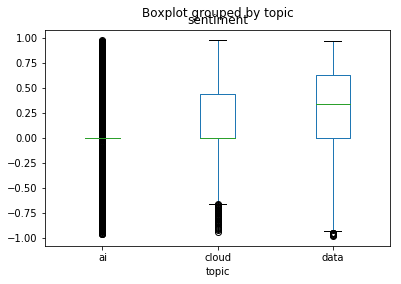

In [84]:
# Boxplot sentiments by topic

pdf2.boxplot(by='topic', column=['sentiment'], grid=False)